In [1]:
%pip install torch torchvision torchsummary
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import json
import os

from MiraBest_Goof import MiraBest

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5])])

In [3]:
trainset = MiraBest(root='../batches', train=True, download=True, transform=transform)  
batch_size_train = 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=2)

Files already downloaded and verified


In [4]:
testset = MiraBest(root='../batches', train=False, download=True, transform=transform) 
batch_size_test = 2
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True, num_workers=2)

Files already downloaded and verified


In [5]:
test_len = 0
for i, data in enumerate(testloader, 0):
    x, y = data
    test_len += x.shape[0]
train_len = 0
for i, data in enumerate(trainloader, 0):
    x, y = data
    train_len += x.shape[0]
print(test_len)
print(train_len)


77
693


In [6]:
dataset_sizes = {"train": train_len, "test": test_len}

In [41]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 3, 3)
        self.conv3 = nn.Conv2d(3, 6, 3)
        # self.fc1 = nn.Linear(16 * 73 * 73, 120) 
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(6*17*17, 2) 

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = x.view(-1, 6*17*17)
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [42]:
net = Net()
summary(net,(1,150,150))
loss = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.01)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 148, 148]              30
            Conv2d-2            [-1, 3, 72, 72]              84
            Conv2d-3            [-1, 6, 34, 34]             168
            Linear-4                    [-1, 2]           3,470
Total params: 3,752
Trainable params: 3,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.67
Params size (MB): 0.01
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


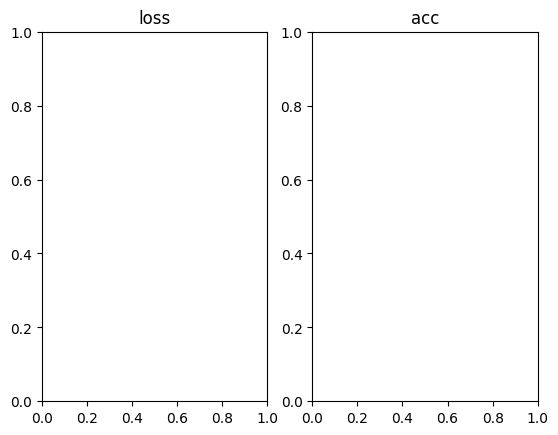

In [43]:
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="acc")

y_loss = {}
y_loss["train"] = []
y_loss["test"] = []
y_acc = {}
y_acc["train"] = []
y_acc["test"] = []
#https://sybernix.medium.com/drawing-loss-curves-for-deep-neural-network-training-in-pytorch-ac617b24c388

def draw_curve():
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['test'], 'ro-', label='test')
    ax1.plot(x_epoch, y_acc['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_acc['test'], 'ro-', label='test')
    file_name = "train_" + str(len(x_epoch)) + ".jpg"
    fig.savefig(os.path.join('../lossGraphs_v1', file_name))

In [44]:
num_epochs = 20
for epoch in range(num_epochs):
    print('-' * 20)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    for phase in ["train", "test"]:     
        running_loss = 0.0
        running_corrects = 0.0 
        if(phase == "train"):
            net.train(True)
            for i, data in enumerate(trainloader, 0):
                images, labels = data
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        else:
            net.train(False)
            for i, data in enumerate(testloader, 0):
                images, labels = data
                now_batch_size, c, h, w = images.shape
                optimizer.zero_grad()
                outputs = net(images)
                _, predictions = torch.max(outputs.data, 1)
                l = loss(outputs, labels)

                running_loss += l.item() * now_batch_size
                del l
                running_corrects += float(torch.sum(predictions == labels.data))
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{}: Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        y_loss[phase].append(epoch_loss)
        y_acc[phase].append(epoch_acc)
        if(phase == "test"):
            x_epoch.append(epoch)
            draw_curve()
        

--------------------
Epoch 1/20
train: Loss: 0.6918 Acc: 0.5541
test: Loss: 0.6837 Acc: 0.5974
--------------------
Epoch 2/20
train: Loss: 0.6824 Acc: 0.6190
test: Loss: 0.6655 Acc: 0.5584
--------------------
Epoch 3/20
train: Loss: 0.6690 Acc: 0.6349
test: Loss: 0.6407 Acc: 0.6623
--------------------
Epoch 4/20
train: Loss: 0.6393 Acc: 0.6667
test: Loss: 0.5995 Acc: 0.7532
--------------------
Epoch 5/20
train: Loss: 0.6065 Acc: 0.6797
test: Loss: 0.5789 Acc: 0.7662
--------------------
Epoch 6/20
train: Loss: 0.5800 Acc: 0.7085
test: Loss: 0.5868 Acc: 0.7013
--------------------
Epoch 7/20
train: Loss: 0.5593 Acc: 0.7215
test: Loss: 0.5728 Acc: 0.7532
--------------------
Epoch 8/20
train: Loss: 0.5416 Acc: 0.7302
test: Loss: 0.5876 Acc: 0.7143
--------------------
Epoch 9/20
train: Loss: 0.5271 Acc: 0.7374
test: Loss: 0.5766 Acc: 0.7143
--------------------
Epoch 10/20
train: Loss: 0.5117 Acc: 0.7590
test: Loss: 0.5771 Acc: 0.7273
--------------------
Epoch 11/20
train: Loss: 0.5

In [46]:
net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.1151, -0.0799,  0.5454],
                        [-0.2093, -0.2734,  0.1755],
                        [-0.3728,  0.2621, -0.0670]]],
              
              
                      [[[-0.0938,  0.2398,  0.1491],
                        [-0.2567,  0.3145,  0.1904],
                        [-0.2756, -0.3029, -0.0900]]],
              
              
                      [[[-0.3021,  0.5320,  0.2724],
                        [-0.1969,  0.5068,  0.5883],
                        [-0.1914,  0.5127, -0.0762]]]])),
             ('conv1.bias', tensor([-0.1261, -0.1090,  0.0484])),
             ('conv2.weight',
              tensor([[[[ 0.3209,  0.2852,  0.3302],
                        [-0.0054,  0.2039,  0.2018],
                        [ 0.2615,  0.5314,  0.5129]],
              
                       [[ 0.1768,  0.1822,  0.0129],
                        [-0.1741,  0.1091,  0.0980],
                        [-0.0923,  0.1898,  0.0

In [ ]:
torch.save(net.state_dict(), "model.pth")

# newmodel = Multiclass()
# with open("model.pickle", "rb") as fp:
#     newmodel.load_state_dict(pickle.load(fp))
